In [2]:
import math
import numpy as np
#from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [3]:

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import ToPILImage
from torch.utils.tensorboard import SummaryWriter

In [4]:
filename = 'SineSeriesDDPM_SSS.pt'         #Save and Load the correct filename

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
class Forward_diffussion_process():
  def __init__(self, start, end, timesteps):
    self.start = start
    self.end = end
    self.steps = timesteps

  def noise_scheduler(self):
    beta = torch.linspace(self.start, self.end, self.steps)
    return beta

  def get_index(self, values, t, x_shape):  ##x_shape - shape of input images (32, 3, 64, 64)  (N - batch_size, channels, height, width)
    batch_size = t.shape[0] 
    out = values.gather(-1, t.cpu())  #gather aplha_bar_t th index from alpha cumprod, from last-dim
    #print(out)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

  def mean_var_helper(self):  ##to get posterior variance and mean for sampling   [bar <=> cumprod]
    #Posterior variance
    beta = self.noise_scheduler()
    alpha = 1. - beta
    alpha_cumprod = torch.cumprod(alpha, axis=0)  #alpha_bar
    alpha_cumprod_shifted = F.pad(alpha_cumprod[:-1], (1, 0), value=1.0)  #alpha_bar_t_minus_one
    sqrt_recip_alpha = torch.sqrt(1.0 / alpha)  #1/sqrt(alpha)
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)  #sqrt(alpha_bar)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1. - alpha_cumprod) #sqrt(1- alpha_bar)|

    posterior_variance = beta * (1. - alpha_cumprod_shifted) / (1. - alpha_cumprod)
    return posterior_variance, sqrt_recip_alpha, beta, sqrt_one_minus_alpha_cumprod


  def forward_diffusion_sample(self, input_image, t):
    ##gaussian noise
    epsilon = torch.randn_like(input_image).to(device)
    beta = self.noise_scheduler()
    alpha = 1. - beta
    alpha_cumprod = torch.cumprod(alpha, axis=0)  #alpha_bar
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)  #sqrt(aplha_t)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - alpha_cumprod) #sqrt(1 - aplha_t)
    sqrt_acp_at_t = self.get_index(sqrt_alpha_cumprod,
                                   t,
                                   input_image.shape,).to(device)

    sqrt_one_minus_acp_at_t = self.get_index(sqrt_one_minus_alpha_cumprod,
                                   t,
                                   input_image.shape).to(device)
    #print(f"Shape of sqrt_acp_at_t:{sqrt_acp_at_t.shape}")
    #print(f"Shape of sqrt_one_minus_acp_at_t:{sqrt_one_minus_acp_at_t.shape}")
    #print(f"Shape of epsilon:{epsilon.shape}")
    ##xt = (Input_image) * sqrt(alphas_cumprod (till timestep t)) + (sqrt(1-alphas_cumprod (till timestep t))) * epsilon, epsilon ~ N(0,1)

    return sqrt_acp_at_t * input_image + sqrt_one_minus_acp_at_t * epsilon, epsilon

In [7]:
T = 1000
fdp = Forward_diffussion_process(0.0001, 0.02, T)

In [8]:
class TimeEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv1d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose1d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv1d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv1d(out_ch, out_ch, 4, stride = 2, padding= 1)
        self.conv2 = nn.Conv1d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm1d(out_ch)
        self.bnorm2 = nn.BatchNorm1d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        #print(f"Shape of x:{x.shape}")
        h = self.bnorm1(self.relu(self.conv1(x)))
        #print(f"Shape of h:{h.shape}")
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[..., None]
        #print(f"Shape of time_emb:{time_emb.shape}")
        h = h + time_emb
        return self.transform(h)

In [10]:
class Unet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_embed = nn.Sequential(
                TimeEmbeddings(time_emb_dim), #o/p: (64,32) position embeddings
                nn.Linear(time_emb_dim, time_emb_dim), #inputs: (64,32), outputs: (64,32)
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.Linear(time_emb_dim, time_emb_dim)
            )

        self.conv0 = nn.Conv1d(image_channels, down_channels[0], 3, padding=1)  ##output after this layer: (64 or 32, 3, 64, 64)


        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])

        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv1d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        #print(f"timestep device:{timestep.device}")
        t = self.time_embed(timestep)
        #print(f"Shape of t:{t.shape}")
        x = self.conv0(x)
        #print(f"Shape of x:{x.shape}")
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            #print(f"Shape of x in downsample:{x.shape}")
            residual_inputs.append(x)
            nn.Dropout(p=0.1)

        for up in self.ups:
            nn.Dropout(p=0.1)
            residual_x = residual_inputs.pop()
            #print(f"Shape of residual_x:{residual_x.shape}")
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        out = self.output(x)
        return out

In [11]:
unet_model = Unet().to(device)

In [12]:
num_epochs = 250
input_curve = torch.load('sinusoidal_curve_SSS.pt')
input_curve = input_curve.to(device)
full_size = input_curve.shape[0]          #Get Total number of Data
batch_size = 100

In [13]:
unet_model.train()    
from torch.optim import Adam
optimizer = Adam(unet_model.parameters(), lr = 1e-4)
#def F1_loss(noise, noise_pred):
  #return F.l1_loss(noise, noise_pred) 
criterion = nn.MSELoss()    

In [14]:
loss_per_epoch = np.zeros(shape=(num_epochs),dtype = float)
for epoch in range(num_epochs):
  epoch_loss = 0
  num_batches = 0
  for i in range(full_size//batch_size):
    optimizer.zero_grad()
    x = input_curve[i*batch_size:(i+1)*batch_size,:,:]
    t = torch.randint(0, T, (batch_size,), device = device).long()
    x = x.to(device)
    #print(f"x device:{x.device}")
    #print(f"T device:{t.device}")

    x_noisy, noise = fdp.forward_diffusion_sample(x, t)  #Get noisy image and corresponding noise
    model_noise_pred = unet_model(x_noisy, t)  #Predict the noise using the UNet model
    loss = criterion(noise, model_noise_pred)  #Compute L2 loss between actual noise and predicted noise
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    num_batches += 1

  ##logging average loss   
  avg_loss = epoch_loss / num_batches
  loss_per_epoch[epoch] = avg_loss  
  #writer.add_scalar('Loss/train', avg_loss, epoch)  #Logging average loss per epoch to tensorboard
  torch.save(unet_model,filename) 
  print(f'Loss in epoch{epoch+1}: {loss.item()}')
torch.save(unet_model,filename)


Loss in epoch1: 0.045486606657505035
Loss in epoch2: 0.039759911596775055
Loss in epoch3: 0.016079559922218323
Loss in epoch4: 0.018541734665632248
Loss in epoch5: 0.013820409774780273
Loss in epoch6: 0.0117231709882617
Loss in epoch7: 0.010657270438969135
Loss in epoch8: 0.011243892833590508
Loss in epoch9: 0.017911583185195923
Loss in epoch10: 0.009029645472764969
Loss in epoch11: 0.007261643186211586
Loss in epoch12: 0.009303353726863861
Loss in epoch13: 0.006172382738441229
Loss in epoch14: 0.006961734499782324
Loss in epoch15: 0.014434539712965488
Loss in epoch16: 0.005659456364810467
Loss in epoch17: 0.010146990418434143
Loss in epoch18: 0.008556840009987354
Loss in epoch19: 0.008729645051062107
Loss in epoch20: 0.005419217515736818
Loss in epoch21: 0.005174884106963873
Loss in epoch22: 0.0058084395714104176
Loss in epoch23: 0.004336062353104353
Loss in epoch24: 0.005226265639066696
Loss in epoch25: 0.00530900526791811
Loss in epoch26: 0.00513340812176466
Loss in epoch27: 0.00500

In [44]:
torch.save(loss_per_epoch,"epoch_loss_SineSSS.pt")

In [45]:
#unet_model.train()

In [46]:
@torch.no_grad()
def sample_image_at_t(x_t, t, posterior_variance, sqrt_recip_alpha, beta, sqrt_one_minus_alpha_cumprod):

    beta_t = fdp.get_index(beta, t, x_t.shape)
    sqrt_one_minus_alphas_cumprod_t = fdp.get_index(
        sqrt_one_minus_alpha_cumprod, t, x_t.shape
    )
    sqrt_recip_alphas_t = fdp.get_index(sqrt_recip_alpha, t, x_t.shape)


    model_mean = sqrt_recip_alphas_t * (
        x_t - beta_t * unet_model(x_t, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = fdp.get_index(posterior_variance, t, x_t.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x_t)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


In [47]:
@torch.no_grad()
def sample_image(k):
    # Sample noise
    img = torch.randn((1, 1, seq_len), device=device)
    plt.figure(figsize=(15,1))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    posterior_variance, sqrt_recip_alpha, beta, sqrt_one_minus_alpha_cumprod = fdp.mean_var_helper()

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        x_t_minus_1 = sample_image_at_t(img, t, posterior_variance, sqrt_recip_alpha, beta, sqrt_one_minus_alpha_cumprod)  
        img = torch.clamp(x_t_minus_1, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, num_images - int(i/stepsize))
            plt.imshow(reverse_transforms(img.detach().cpu()),cmap = 'gray')
            plt.title(f't = {t.item()}')
            plt.axis('off')
    #plt.savefig(f'CIFAR10_output_{k}.png')
    plt.show()

In [48]:
#unet_model = torch.load(filename,weights_only=False,map_location=torch.device('cpu'))
unet_model.eval()

Unet(
  (time_embed): Sequential(
    (0): TimeEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (conv0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(128, 128, kernel_size=(4,), stride=(2,), padding=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv1d(128, 256, kernel_si

In [49]:
seq_len = input_curve.shape[-1]
print(seq_len)

400


In [50]:
noisy_series = torch.randn((50, 1, seq_len), device=device)
posterior_variance, sqrt_recip_alpha, beta, sqrt_one_minus_alpha_cumprod = fdp.mean_var_helper()
for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        noisy_series = sample_image_at_t(noisy_series, t, posterior_variance, sqrt_recip_alpha, beta, sqrt_one_minus_alpha_cumprod)
print(noisy_series.shape)

torch.Size([50, 1, 400])


In [51]:
for i in range(50):
    plt.plot(noisy_series[i,0,:].detach().cpu())
    plt.ylabel('Amplitude')
    plt.savefig(f'./figures/sineSSS/fig_{i}')
    plt.close()

In [52]:
loss_data = torch.load("epoch_loss_SineSSS.pt", weights_only = False)

In [53]:
print(loss_data.shape)

(250,)


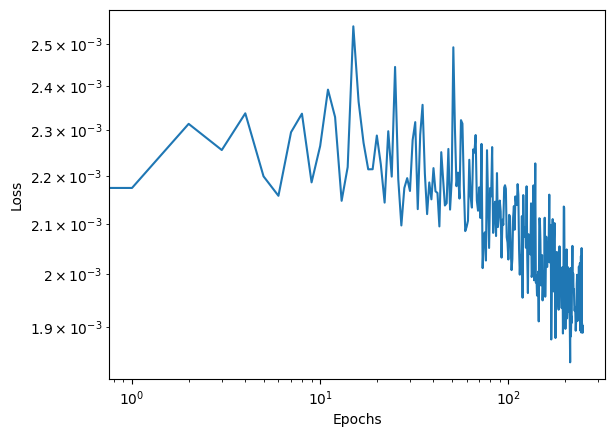

In [54]:
plt.plot(loss_data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./figures/sineSSS/lossPlot.png')